In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

## error metrics:
from sklearn.metrics import mean_squared_error

In [4]:
def predict_with_last_year(target, time_units_year):
    """
    Returns the last year of a temporal serie as a prediction for the next year.
    
        Parameters:
            target (array/list/pd.Serie): An array of (n,1) dimensions
            time_units_year (int): An integer to determine the number of units in which we divide each year (e.g 12 in the case of months)
        
        Returns:
            target_predicted(array): prediction for the future and unknow year
    """
    y = np.asarray(target)
    y = y.reshape(len(y),1)
    
    target_predicted = y[-time_units_year:]
    return target_predicted

In [5]:
## we load our training data in order to see how the year 2018 fits the 2019
## by the way, we will use the concrect info of the product family 2:
yTrain = pd.read_pickle("C:/Users/Javier/documents/GIT/Repositories/TFM-Textil-Santanderina/notebooks/experiments/study_by_group/yTrainf_2.pkl")
yTest = pd.read_pickle("C:/Users/Javier/documents/GIT/Repositories/TFM-Textil-Santanderina/notebooks/experiments/study_by_group/yTest_f2")

In [6]:
prediction_with_ly_19 = predict_with_last_year(yTrain, 48)

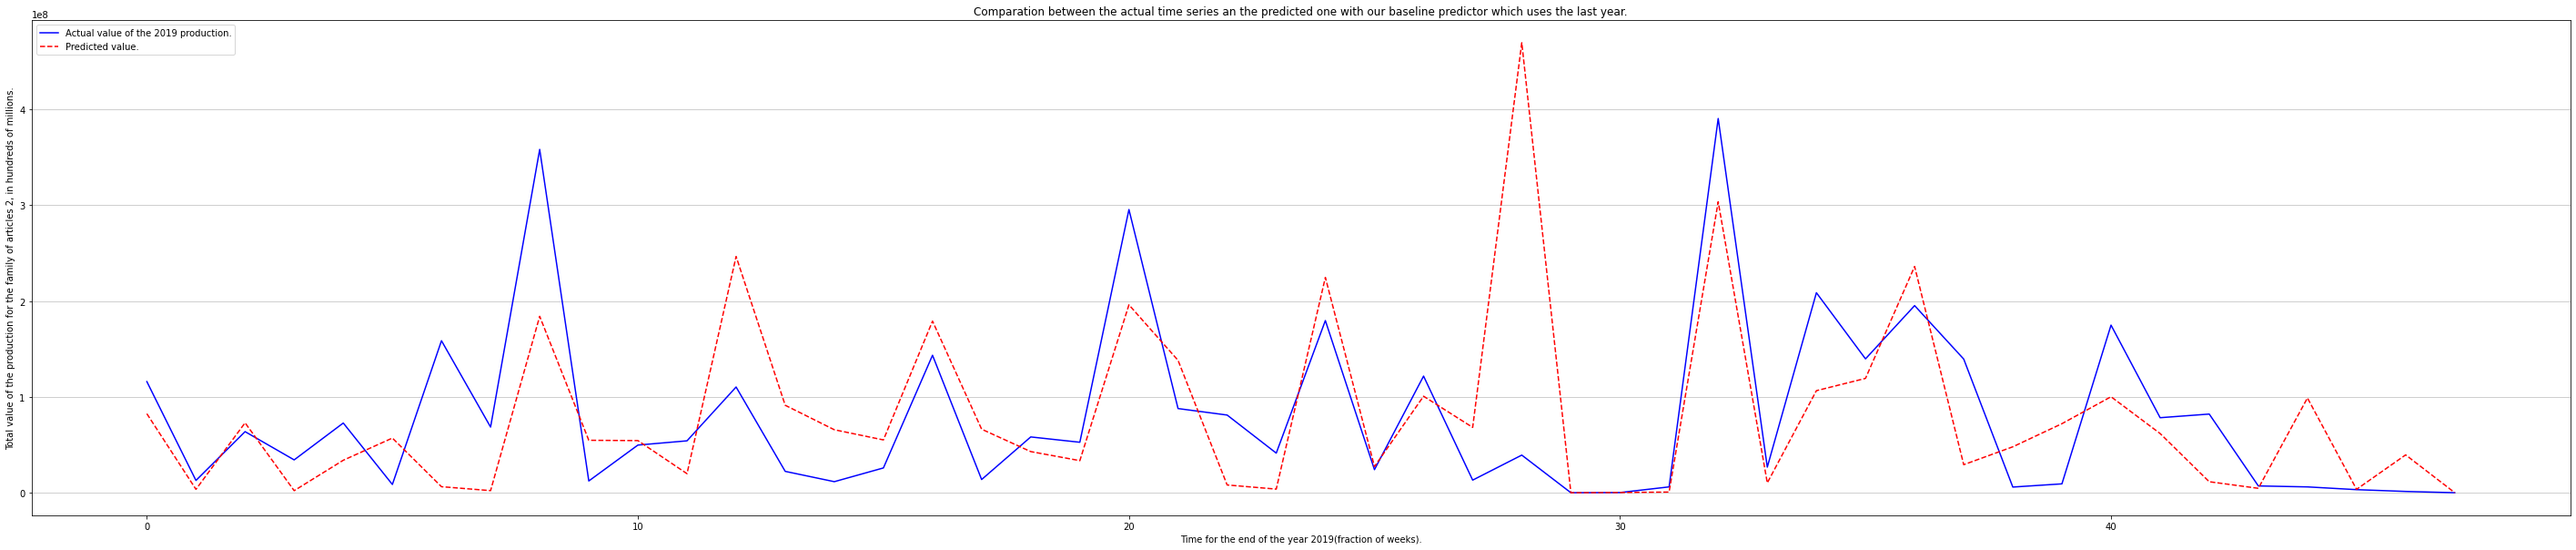

In [30]:
from pylab import rcParams
ax = plt.figure().add_subplot(111)
ax.plot(yTest,'-b', label = 'Actual value of the 2019 production.')
ax.plot(prediction_with_ly_19, '--r', label = 'Predicted value.')
ax. legend(loc='upper left')
plt.title('Comparation between the actual time series an the predicted one with our baseline predictor which uses the last year.')
plt.xlabel('Time for the end of the year 2019(fraction of weeks).')
plt.ylabel('Total value of the production for the family of articles 2, in hundreds of millions.')

plt.grid(axis='y', alpha=0.75)

rcParams['figure.figsize'] = 50, 10

In [8]:
y_true = yTest.target

mean_squared_error(y_true, prediction_with_ly_19)

7663494856185407.0

In [69]:
## our idea is to add these baseline predictors to our general module:
def predict_with_ema(target, time_units_year, alpha):
    """
    Returns Exponential Moving Average for any single time segmentation of our predicted time serie.
    
        Parameters:
            target (array/list/pd.Serie): An array of (n,1) dimensions
            time_units_year (int): An integer to determine the number of units in which we divide each year (e.g 12 in the case of months)
            alpha (float): its value should be between 0 and 1, is the importance we give to our most recent observation, thus been (1-alpha) the importance to the rest of observations
        Returns:
            target_predicted(array): prediction for  of an unknow (next) year. Note that each of the 
    """
    y = np.asarray(target)
    y = y.reshape(len(y),1)
    
    ## to know the number of years we have in our training time serie:
    ## we change its type as integer for the future iterations:
    num_years = int(len(y)/time_units_year)
    
    ## we need to split our training target information in a different array for each year:
    y_divided = np.array_split(y,num_years)
    
    ## now we iterate the process of calculating the EMA for each time unit
    ## taking as references the same times in different years:
    target_predicted = np.empty(0)
    for time_unit_i in range(0, time_units_year):
        same_time_array = np.empty(0)
        for year_serie in range(0,num_years):
            same_time = y_divided[year_serie][time_unit_i]
            same_time_array = np.append(same_time_array,same_time)
        same_time_array = pd.Series(same_time_array)
        ema_unit_time = same_time_array.ewm(alpha=alpha, adjust=False).mean()[-1:]
        target_predicted = np.append(target_predicted, ema_unit_time)
        
    return target_predicted

In [90]:
prediction_with_ema_19= predict_with_ema(yTrain, 48, alpha=0.1)

Alpha 0.1obtains an rmse error of 4.725007e+15.
Alpha 0.25obtains an rmse error of 3.527489e+15.
Alpha 0.5obtains an rmse error of 3.798770e+15.
Alpha 0.75obtains an rmse error of 5.461399e+15.
Alpha 0.9obtains an rmse error of 6.760996e+15.


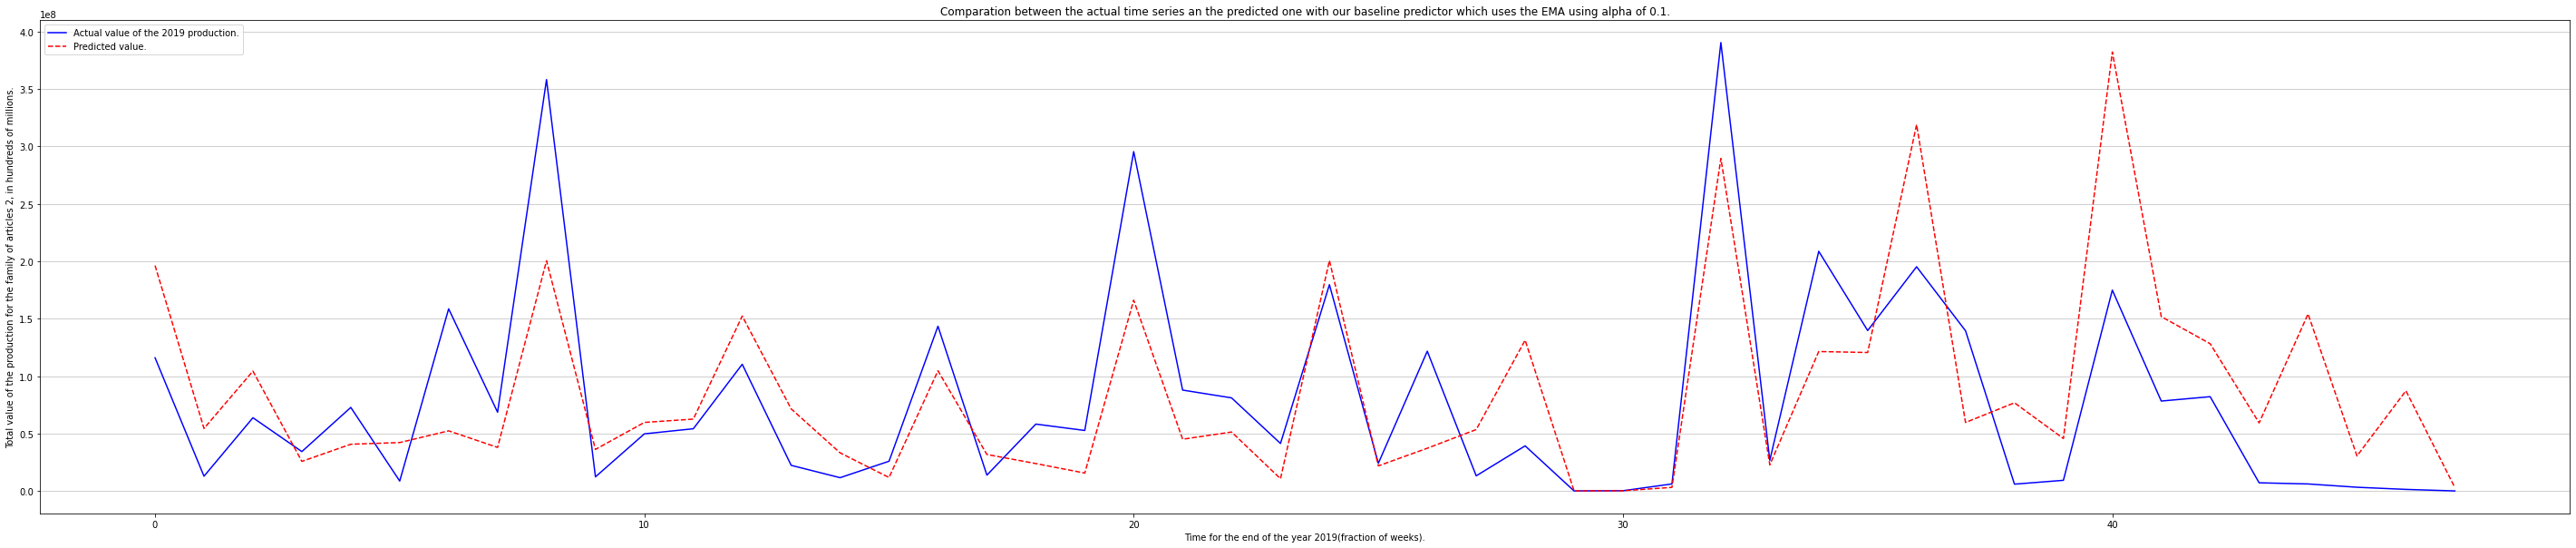

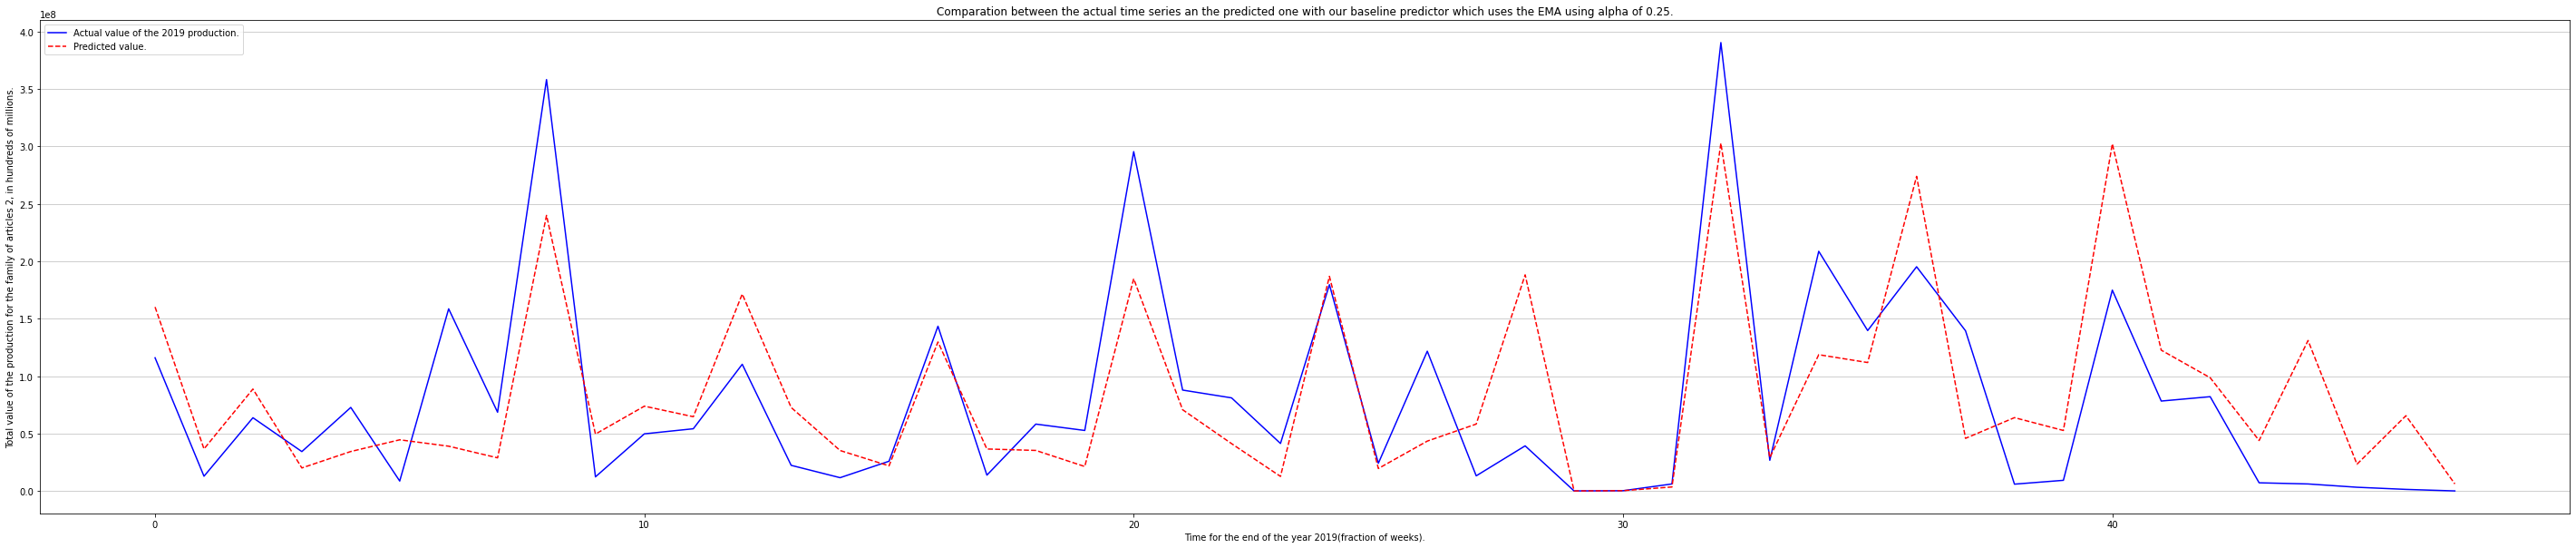

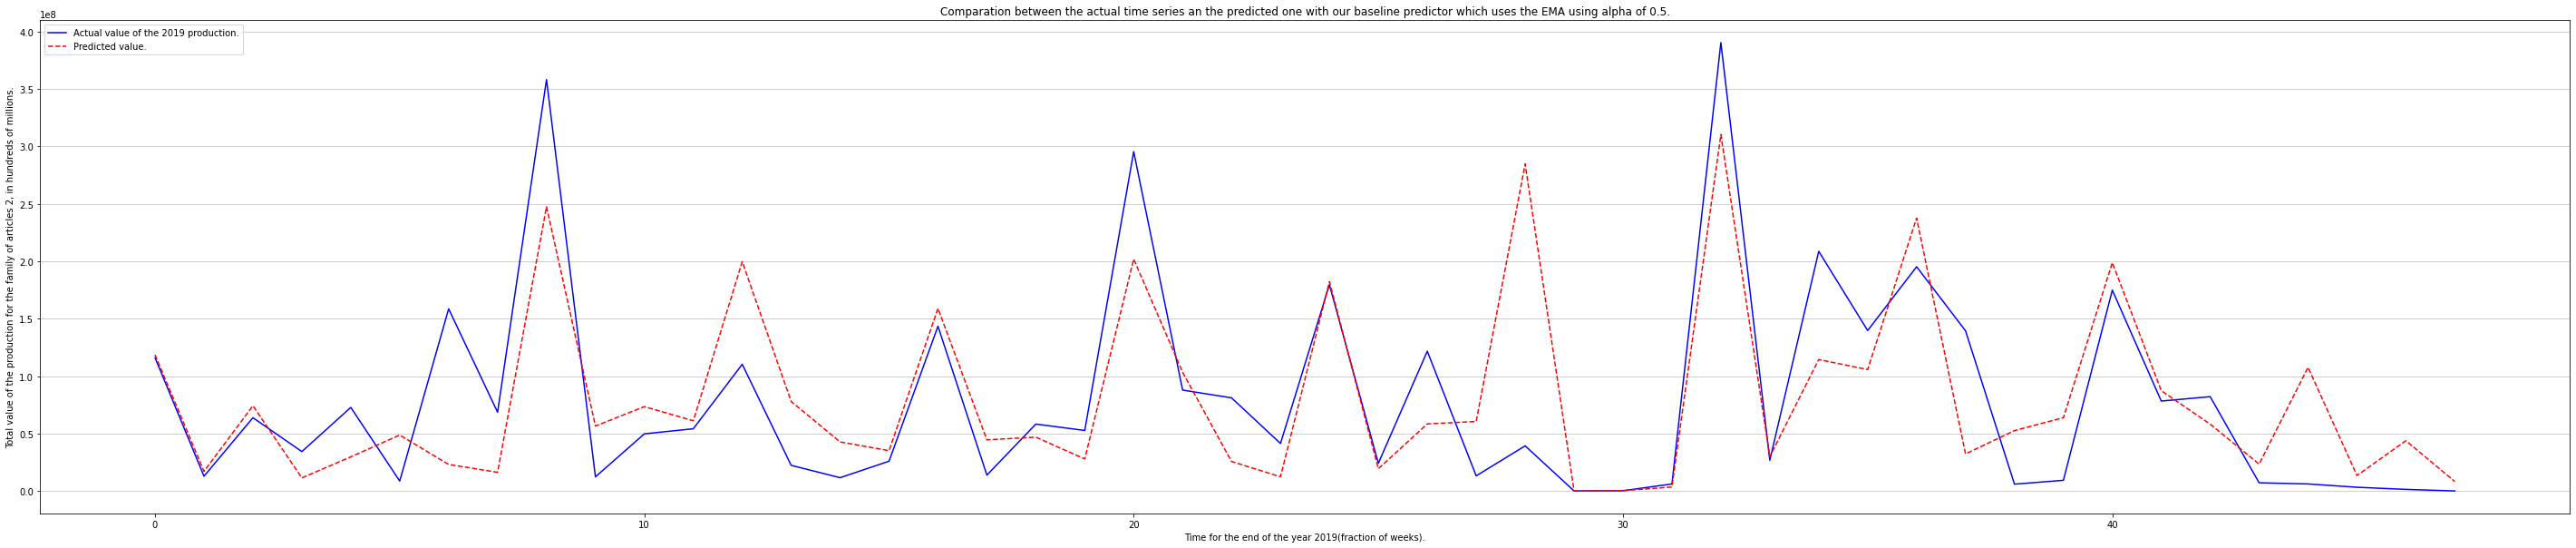

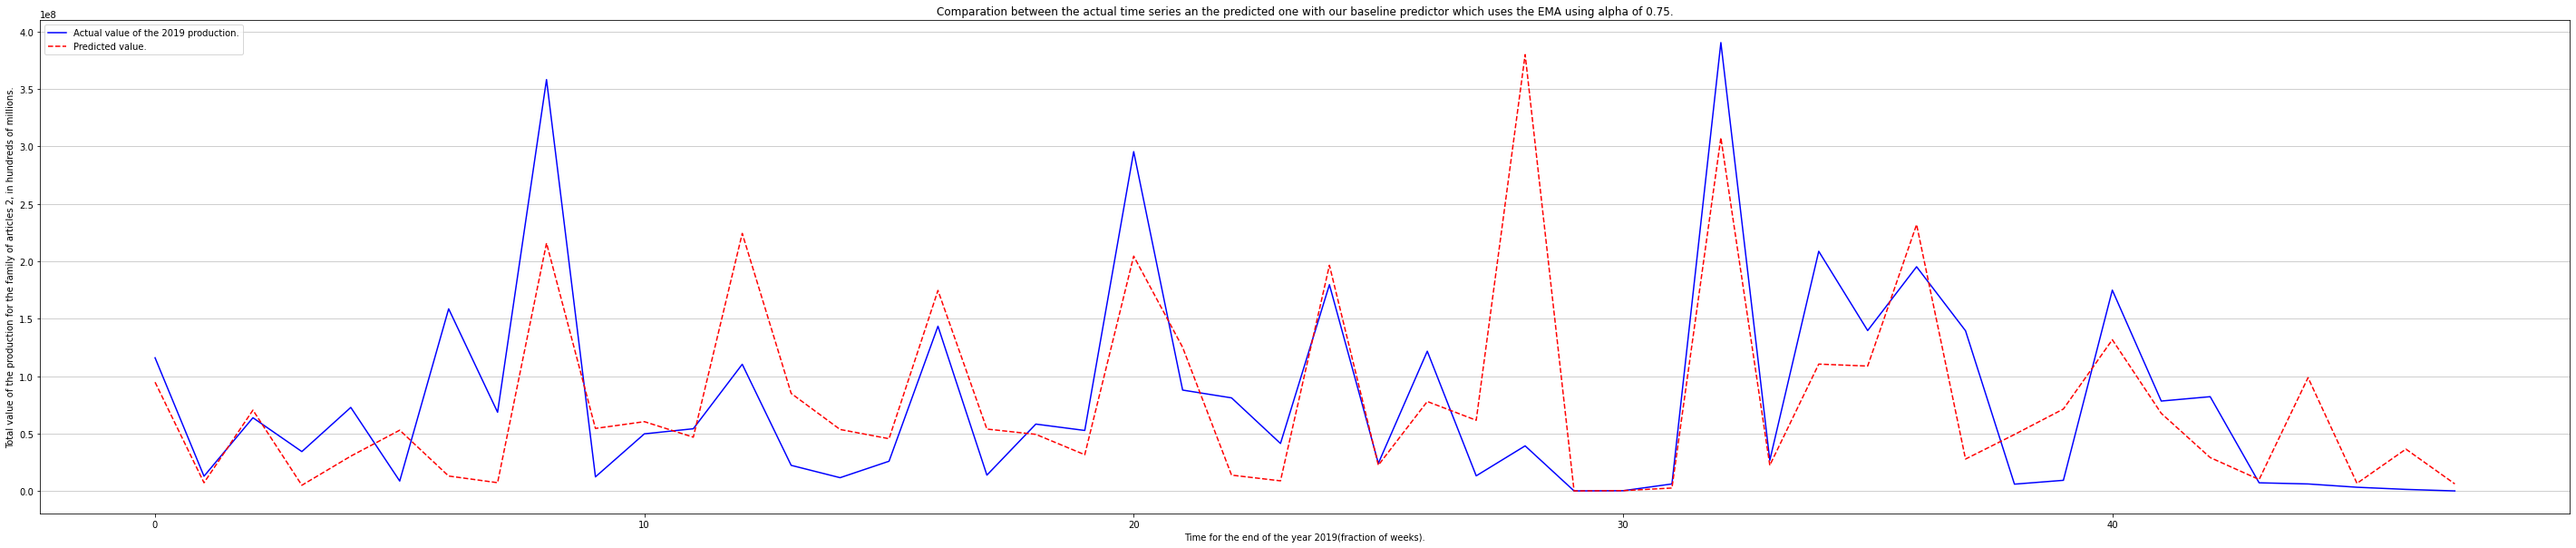

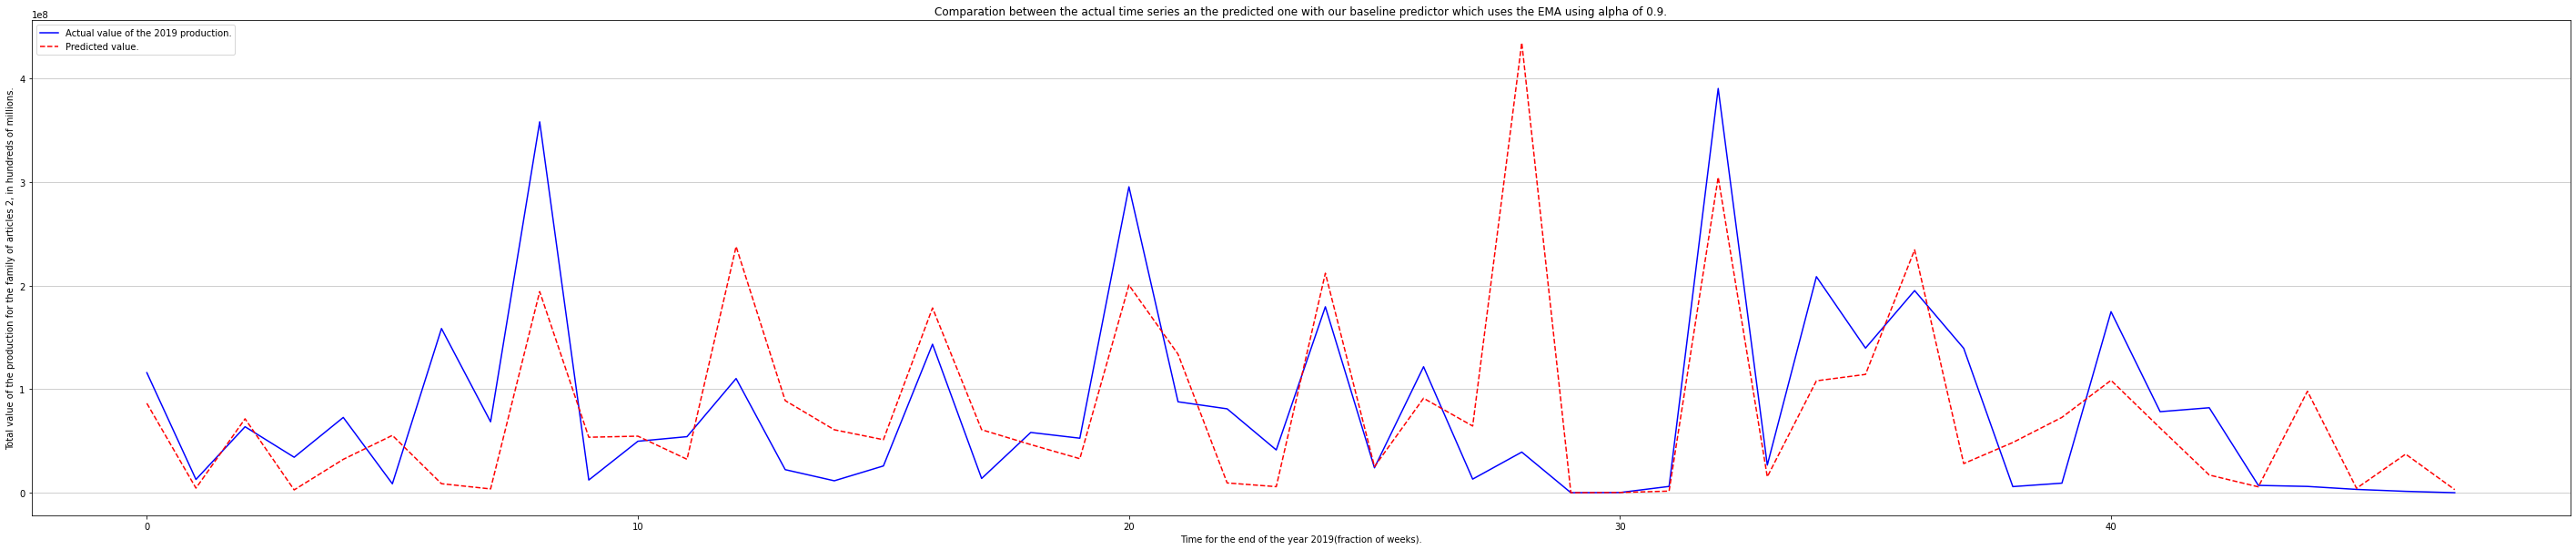

In [108]:
lista = [0.1,0.25,0.5,0.75,0.9]
for value_alpha in lista:
    prediction_with_ema_19= predict_with_ema(yTrain, 48, alpha=value_alpha)

    from pylab import rcParams
    ax = plt.figure().add_subplot(111)
    ax.plot(yTest,'-b', label = 'Actual value of the 2019 production.')
    ax.plot(prediction_with_ema_19, '--r', label = 'Predicted value.')
    ax. legend(loc='upper left')
    plt.title('Comparation between the actual time series an the predicted one with our baseline predictor which uses the EMA using alpha of '+str(value_alpha)+'.')
    plt.xlabel('Time for the end of the year 2019(fraction of weeks).')
    plt.ylabel('Total value of the production for the family of articles 2, in hundreds of millions.')
    plt.grid(axis='y', alpha=0.75)
    rcParams['figure.figsize'] = 50, 10
    error = mean_squared_error(y_true, prediction_with_ema_19)
    print('Alpha '+str(value_alpha)+'obtains an rmse error of '+"{:e}".format(error)+'.')
    